In [ ]:
# !pip install efficientnet_pytorch
!pip install transformers

# from efficientnet_pytorch import EfficientNet

import torch
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.special import softmax
import cv2
from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW
from tqdm.notebook import tqdm
from albumentations import *
from albumentations.pytorch import ToTensor
import gc

import warnings
warnings.filterwarnings("ignore")

## Visualize a leaf of each category

The categories include "healthy", "scab", "rust", and "multiple diseases". Solving this problem is important because diagnosing plant diseases early can save tonnes of agricultural produce every year. This will benefit not only the general population by reducing hunger, but also the farmers by ensuring they get the harvest they deserve.


Text(0.5, 1.0, 'Scab')

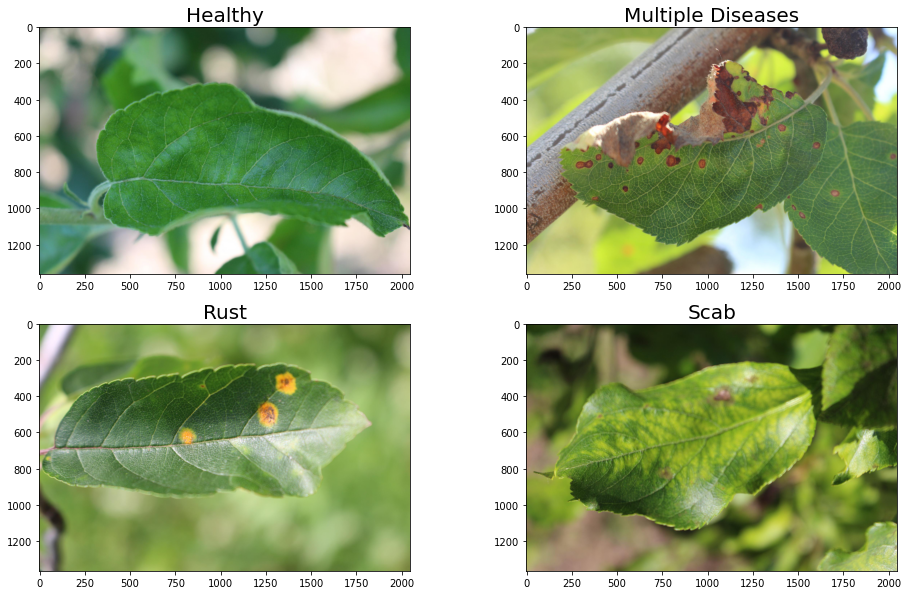

In [ ]:
im_healthy = plt.imread('/content/drive/MyDrive/SML/images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread('/content/drive/MyDrive/SML/images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('/content/drive/MyDrive/SML/images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread('/content/drive/MyDrive/SML/images/Train_0.jpg', format = 'jpg')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title('Healthy', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title('Multiple Diseases', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title('Rust', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title('Scab', fontsize = 20)

## Load image paths and labels into DataFrame

The dataset images are loaded, resized to the desired size and saved as .npy files. This allows them to be loaded up really fast, preventing the data loading process from bottlenecking the GPU training.

[The .npy files can be accessed here](http://www.kaggle.com/dataset/cbf0d20bb9deea2b794018659843387bd18e2a8638fae654e996c2b660cfdffb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_FOLDER = '/content/drive/MyDrive/SML/image_pickles/'

def get_image_path(filename):
    return (IMAGE_FOLDER + filename + '.npy')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/SML/train.csv')
test = pd.read_csv('/content/drive/MyDrive/SML/test.csv')

train['image_path'] = train['image_id'].apply(get_image_path)
test['image_path'] = test['image_id'].apply(get_image_path)
train_labels = train.loc[:, 'healthy':'scab']
train_paths = train.image_path
test_paths = test.image_path

## Create train-validation split

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

In [ ]:
class LeafDataset(Data.Dataset):
    def __init__(self, image_paths, labels = None, train = True, test = False):
        self.paths = image_paths
        self.test = test
        if self.test == False:
            self.labels = labels
        self.train = train
        self.train_transform = Compose([HorizontalFlip(p=0.5),
                                  VerticalFlip(p=0.5),
                                  ShiftScaleRotate(rotate_limit=25.0, p=0.7),
                                  OneOf([IAAEmboss(p=1),
                                         IAASharpen(p=1),
                                         Blur(p=1)], p=0.5),
                                  IAAPiecewiseAffine(p=0.5)])
        self.test_transform = Compose([HorizontalFlip(p=0.5),
                                       VerticalFlip(p=0.5),
                                       ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
        self.default_transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                         ToTensor()]) #normalized for pretrained network
        
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i):
        image = np.load(self.paths[i]) #load from .npy file!
        if self.test==False:
            label = torch.tensor(np.argmax(self.labels.loc[i,:].values)) #loss function used later doesnt take one-hot encoded labels, so convert it using argmax
        if self.train:
            image = self.train_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        elif self.test:
            image = self.test_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        else:
            image = self.default_transform(image=image)['image']
        
        if self.test==False:
            return image, label
        return image

## Define training, validation and test functions

In [ ]:
def train_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Training')
    
    for _, (images, labels) in enumerate(loader):
        
        images, labels = images.to(device), labels.to(device)
        net.train()
        optimizer.zero_grad()
        predictions = net(images)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()*labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        pbar.update()
        
    accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/TRAIN_SIZE, accuracy

def valid_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (images, labels) in enumerate(loader):
            
            images, labels = images.to(device), labels.to(device)
            net.eval()
            predictions = net(images)
            loss = loss_fn(predictions, labels)
            
            running_loss += loss.item()*labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = accuracy_score(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat

def test_fn(net, loader):

    preds_for_output = np.zeros((1,4))
    
    with torch.no_grad():
        pbar = tqdm(total = len(loader))
        for _, images in enumerate(loader):
            images = images.to(device)
            net.eval()
            predictions = net(images)
            preds_for_output = np.concatenate((preds_for_output, predictions.cpu().detach().numpy()), 0)
            pbar.update()
    
    pbar.close()
    return preds_for_output

## Initialize

In [ ]:
BATCH_SIZE = 6
NUM_EPOCHS = 30
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]
device = 'cuda'
lr = 8e-4

In [ ]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths, train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

## Resnet18


In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs,1000,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1000,4, bias = True))

model.to(device)
optimizer = AdamW(model.parameters(), lr = lr, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

## Main training loop

In [ ]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = train_fn(model, loader = trainloader)
    vl, va, conf_mat = valid_fn(model, loader = validloader)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        path = 'epoch' + str(epoch) + '.pt'
        torch.save(model.state_dict(), path)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    
'''Output hidden. Unhide to see training log'''


Epoch: 0, Train loss: 0.8453104182013443, Val loss: 0.3411589731806762, Train acc: 0.6538461538461539, Val acc: 0.8821917808219178



Epoch: 1, Train loss: 0.5134068292432598, Val loss: 0.23036205753275793, Train acc: 0.8468406593406593, Val acc: 0.9342465753424658



Epoch: 2, Train loss: 0.504346337926748, Val loss: 0.579352548549411, Train acc: 0.8434065934065934, Val acc: 0.8465753424657534



Epoch: 3, Train loss: 0.493315417199283, Val loss: 0.25293257847836575, Train acc: 0.8509615384615384, Val acc: 0.9260273972602739



Epoch: 4, Train loss: 0.4768909556409958, Val loss: 0.44166521816067905, Train acc: 0.8715659340659341, Val acc: 0.8904109589041096



Epoch: 5, Train loss: 0.5604592917991065, Val loss: 0.4194010932559836, Train acc: 0.8399725274725275, Val acc: 0.8657534246575342



Epoch: 6, Train loss: 0.5014796984665976, Val loss: 0.29461451483099427, Train acc: 0.8592032967032966, Val acc: 0.915068493150685



Epoch: 7, Train loss: 0.42371880429653597, Val loss: 0.28558354749765297, Train acc: 0.8777472527472527, Val acc: 0.9260273972602739



Epoch: 8, Train loss: 0.38392630380138265, Val loss: 0.6342221618515171, Train acc: 0.8928571428571429, Val acc: 0.8438356164383561



Epoch: 9, Train loss: 0.3566028777366647, Val loss: 0.2999350575921572, Train acc: 0.8942307692307693, Val acc: 0.9123287671232877



Epoch: 10, Train loss: 0.36830015716930997, Val loss: 0.24932898312092644, Train acc: 0.8921703296703297, Val acc: 0.9342465753424658



Epoch: 11, Train loss: 0.3311892725536242, Val loss: 0.25209211709156426, Train acc: 0.9093406593406593, Val acc: 0.9315068493150684



Epoch: 12, Train loss: 0.3119349858338515, Val loss: 0.40039434215079434, Train acc: 0.9148351648351648, Val acc: 0.8958904109589041



Epoch: 13, Train loss: 0.2990236839651806, Val loss: 0.18226507435208314, Train acc: 0.9175824175824175, Val acc: 0.936986301369863



Epoch: 14, Train loss: 0.2977511518593918, Val loss: 0.23531582084522673, Train acc: 0.9162087912087912, Val acc: 0.9287671232876712



Epoch: 15, Train loss: 0.28742585450751135, Val loss: 0.19544124420579165, Train acc: 0.9196428571428571, Val acc: 0.936986301369863



Epoch: 16, Train loss: 0.23406653855748188, Val loss: 0.17958461345262725, Train acc: 0.9306318681318682, Val acc: 0.9342465753424658



Epoch: 17, Train loss: 0.23763823079183227, Val loss: 0.2365265509470889, Train acc: 0.9271978021978022, Val acc: 0.9232876712328767



Epoch: 18, Train loss: 0.21732558265224786, Val loss: 0.16812200750900458, Train acc: 0.9361263736263736, Val acc: 0.9506849315068493



Epoch: 19, Train loss: 0.19653779159972937, Val loss: 0.2186232108163507, Train acc: 0.9491758241758241, Val acc: 0.9260273972602739



Epoch: 20, Train loss: 0.19479683130227315, Val loss: 0.17488078190498565, Train acc: 0.9395604395604396, Val acc: 0.9506849315068493



Epoch: 21, Train loss: 0.17441326345491048, Val loss: 0.15769511829959612, Train acc: 0.948489010989011, Val acc: 0.9616438356164384



Epoch: 22, Train loss: 0.1728489043283504, Val loss: 0.15570735308303407, Train acc: 0.9498626373626373, Val acc: 0.9561643835616438



Epoch: 23, Train loss: 0.15746231464180419, Val loss: 0.1550888535247682, Train acc: 0.9491758241758241, Val acc: 0.9561643835616438



Epoch: 24, Train loss: 0.14408215230706936, Val loss: 0.15034709682381928, Train acc: 0.9560439560439561, Val acc: 0.958904109589041



Epoch: 25, Train loss: 0.15129243094566186, Val loss: 0.15518937072244612, Train acc: 0.9526098901098901, Val acc: 0.9616438356164384



Epoch: 26, Train loss: 0.14305722880817484, Val loss: 0.14351161716710012, Train acc: 0.9539835164835165, Val acc: 0.9616438356164384



Epoch: 27, Train loss: 0.13659326886313017, Val loss: 0.14467117186406092, Train acc: 0.9567307692307693, Val acc: 0.9616438356164384



Epoch: 28, Train loss: 0.12210161508271115, Val loss: 0.14268227587262652, Train acc: 0.9567307692307693, Val acc: 0.9561643835616438



Epoch: 29, Train loss: 0.11567001979910656, Val loss: 0.14238689103712365, Train acc: 0.9601648351648352, Val acc: 0.958904109589041


'Output hidden. Unhide to see training log'

## Plots of training and validation loss and accuracy

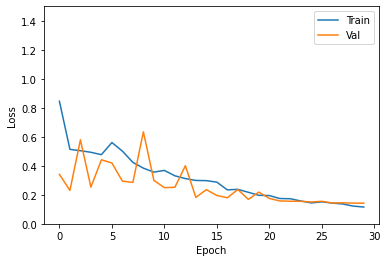

In [ ]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

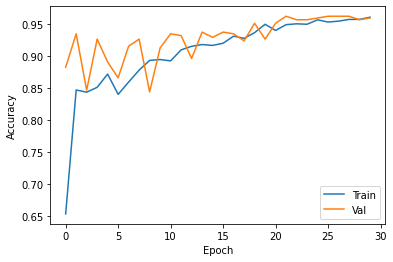

In [ ]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

## Confusion matrix

Computed on the validation set on the last epoch

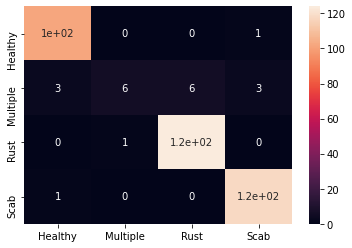

In [ ]:
labels = ['Healthy', 'Multiple','Rust','Scab']
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)